# Emotion recognition based on facial expression using CNN - Testing

In this notebook we will be training the model using all of the data (both train and validation), and then we will use some images that we gathered in order to test it.

Before we start we need to install and import Tensorflow 2.0

In [ ]:
!pip install tensorflow-gpu==2.0

In [ ]:
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.0.0


Let's mount the Google Drive to our notebook. We will use Google Drive as storage for our data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

We made a folder called `full_train`, where we put all train and validation images together. Then we zipped it and uploaded to to Google Drive. We also made a folder for the testing data called `test`, where we gathered some sample test images, i.e. some images that we made of us and some images that we found online. The images are of various shapes and sizes.

Let's unzip both folders from Google Drive to Google Colab.

**Note:** We do this only once per session!

In [ ]:
# EXECUTE THE FOLLOWING CODE JUST ONCE PER SESSION
!unzip -q "/content/drive/My Drive/Colab Notebooks/SML&DL Project/full_train.zip" -d "dataset"
!unzip -q "/content/drive/My Drive/Colab Notebooks/SML&DL Project/test.zip" -d "dataset"

## Hyperparameters

In [ ]:
IMAGE_SIZE = 224          # from "Going Deeper with Convolutions" paper
BATCH_SIZE = 32           # from "Batch Normalization" paper
INITIAL_LRATE = 0.045     # from "Batch Normalization" paper (i.e. 0.0015 multiplied by a factor of 30)
L2_REGULARIZER = 0.00004  # from "Batch Normalization" paper (i.e. 0.0002 divided by a factor of 5)‬
MOMENTUM = 0.9            # from "Going Deeper with Convolutions" paper
EPOCHS = 50

## Data preparation

The dataset consists of 48x48 pixel *grayscale* images of human faces. The images are divided into two major categories: ***train*** and ***validation***. Each of those major categories is divided into 7 sub-categories: ***angry***, ***disgust***, ***fear***, ***happy***, ***neutral***, ***sad*** and ***surprise***.

In [ ]:
# define the project and data paths
project_path = "/content/drive/My Drive/Colab Notebooks/SML&DL Project/"
dataset_path = "dataset/"
full_train_path = dataset_path + "full_train/"
test_data_path = dataset_path + "test/"

Let's count the total number of images in the `full_train` directory.

In [ ]:
import os

# count the number of images
TOTAL_TRAIN_IMAGES = 0

# Train set
print("Train set contains:")
for dir_name in os.listdir(full_train_path):
    temp_len = len(os.listdir(full_train_path + dir_name))
    print("\t" + str(temp_len) + " " + dir_name + " images")
    TOTAL_TRAIN_IMAGES = TOTAL_TRAIN_IMAGES + temp_len

print("\nTotal training images:", TOTAL_TRAIN_IMAGES)

Train set contains:
	547 disgust images
	6077 sad images
	4002 surprise images
	4953 angry images
	5121 fear images
	6198 neutral images
	8989 happy images

Total training images: 35887


We will transform the images, so that they can fit in the input layer of our chosen model. Let's resize the images to 224x224 and change their color mode to rgb.

**Note:** We do this only once per session!

In [ ]:
# EXECUTE THE FOLLOWING CODE JUST ONCE PER SESSION
import cv2

dim = (IMAGE_SIZE, IMAGE_SIZE)

# transform the train dataset
for dir_name in os.listdir(full_train_path):
    for img_name in os.listdir(full_train_path + dir_name):
        img_path = full_train_path + dir_name + "/" + img_name

        # read the image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # resize and colorize the image
        resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        colored = cv2.cvtColor(resized, cv2.COLOR_GRAY2RGB)

        # overwrite the image
        cv2.imwrite(img_path, colored)

# transform the test dataset
for img_name in os.listdir(test_data_path):
    img_path = test_data_path + "/" + img_name

    # read the image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # resize and colorize the image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    colored = cv2.cvtColor(resized, cv2.COLOR_GRAY2RGB)

    # overwrite the image
    cv2.imwrite(img_path, colored)

Let's print an image shape from each of the `full_train` and `test` folders to see if the images are successfully transformed to 224x224 *rgb* images.

In [ ]:
import cv2

img = cv2.imread(full_train_path + 'disgust/10053.jpg', cv2.IMREAD_UNCHANGED)
print('Train folder - disgust/10053.jpg')
print('Original Dimensions: ', img.shape)

img = cv2.imread(test_data_path + '12324.jpg', cv2.IMREAD_UNCHANGED)
print('\nTest folder - 12324.jpg')
print('Original Dimensions: ', img.shape)

Train folder - disgust/10053.jpg
Original Dimensions:  (224, 224, 3)

Test folder - 12324.jpg
Original Dimensions:  (224, 224, 3)


Next we need to format the images into floating point tensors before feeding them to the network. Also, we need to rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

We will use the `ImageDataGenerator` class provided by `tf.keras`, since it automatically does all of that. It will also set up generators that convert these images into batches of tensors, which will be helpful when training the network. Also, since the model has more than one output, we will need to define our own custom generator for multiple outputs.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rescale=1./255)

# custom generator for multiple outputs
def multiple_outputs(generator, image_dir, image_size, color_mode, batch_size, class_mode, shuffle, seed):
    gen = generator.flow_from_directory(image_dir,
                                        target_size=(image_size, image_size),
                                        color_mode=color_mode,
                                        batch_size=batch_size,
                                        class_mode=class_mode,
                                        shuffle=shuffle,
                                        seed=seed)
    while True:
        gnext = gen.next()
        yield gnext[0], [gnext[1], gnext[1], gnext[1]]

train_data_generator = multiple_outputs(train_generator,
                                        full_train_path,
                                        image_size=IMAGE_SIZE,
                                        color_mode="rgb",
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical',
                                        shuffle=True,
                                        seed=21)

We are finished with the data preprocessing!

## Define the model

We will copy the model that we defined in **"Emotion recognition based on facial expression using CNN.ipynb"**.

In [ ]:
from tensorflow.keras import Model, layers, utils
from tensorflow.keras.regularizers import l2

def InceptionModule(inputLayer, params, pull_type):
    _1x1 = params[0]
    _3x3reduce = params[1]
    _3x3 = params[2]
    _double3x3reduce = params[3]
    _double3x3 = params[4]
    _proj = params[5]

    inputNorm = layers.BatchNormalization()(inputLayer)

    # First row (i.e. with the double 3x3 convolution layers):
    double3x3conv1 = layers.Conv2D(filters=_double3x3reduce, kernel_size=1, strides=1, padding='same', activation='relu', kernel_regularizer=l2(l=L2_REGULARIZER))(inputNorm)
    
    double3x3norm2 = layers.BatchNormalization()(double3x3conv1)
    double3x3conv2 = layers.Conv2D(filters=_double3x3, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2(l=L2_REGULARIZER))(double3x3norm2)

    double3x3norm3 = layers.BatchNormalization()(double3x3conv2)
    double3x3conv3 = layers.Conv2D(filters=_double3x3, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2(l=L2_REGULARIZER))(double3x3norm3)

    # Second row (i.e. with the single 3x3 convolution layer):
    single3x3conv1 = layers.Conv2D(filters=_3x3reduce, kernel_size=1, strides=1, padding='same', activation='relu', kernel_regularizer=l2(l=L2_REGULARIZER))(inputNorm)
    
    single3x3norm2 = layers.BatchNormalization()(single3x3conv1)
    single3x3conv2 = layers.Conv2D(filters=_3x3, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2(l=L2_REGULARIZER))(single3x3norm2)

    # Third row (i.e. with the pooling layer):
    if pull_type == "max":
        poolType = layers.MaxPooling2D(pool_size=3, strides=1, padding='same')(inputNorm)

    elif pull_type == "avg":
        poolType = layers.AveragePooling2D(pool_size=7, strides=1, padding='same')(inputNorm)

    poolNorm = layers.BatchNormalization()(poolType)
    poolProj = layers.Conv2D(filters=_proj, kernel_size=1, strides=1, padding='same', activation='relu', kernel_regularizer=l2(l=L2_REGULARIZER))(poolNorm)

    # Fourth row (i.e. with the single 1x1 layer)
    single1x1conv = layers.Conv2D(filters=_1x1, kernel_size=1, strides=1, padding='same', activation='relu', kernel_regularizer=l2(l=L2_REGULARIZER))(inputNorm)

    return layers.Concatenate()([double3x3conv3, single3x3conv2, poolProj, single1x1conv])

def InceptionModule_PassThrough(inputLayer, params):
    _3x3reduce = params[0]
    _3x3 = params[1]
    _double3x3reduce = params[2]
    _double3x3 = params[3]

    inputNorm = layers.BatchNormalization()(inputLayer)

    # First row (i.e. with the double 3x3 convolution layers):
    double3x3conv1 = layers.Conv2D(filters=_double3x3reduce, kernel_size=1, strides=1, padding='same', activation='relu', kernel_regularizer=l2(l=L2_REGULARIZER))(inputNorm)
    
    double3x3norm2 = layers.BatchNormalization()(double3x3conv1)
    double3x3conv2 = layers.Conv2D(filters=_double3x3, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2(l=L2_REGULARIZER))(double3x3norm2)

    double3x3norm3 = layers.BatchNormalization()(double3x3conv2)
    double3x3conv3 = layers.Conv2D(filters=_double3x3, kernel_size=3, strides=2, padding='same', activation='relu', kernel_regularizer=l2(l=L2_REGULARIZER))(double3x3norm3)

    # Second row (i.e. with the single 3x3 convolution layer):
    single3x3conv1 = layers.Conv2D(filters=_3x3reduce, kernel_size=1, strides=1, padding='same', activation='relu', kernel_regularizer=l2(l=L2_REGULARIZER))(inputNorm)
    
    single3x3norm2 = layers.BatchNormalization()(single3x3conv1)
    single3x3conv2 = layers.Conv2D(filters=_3x3, kernel_size=3, strides=2, padding='same', activation='relu', kernel_regularizer=l2(l=L2_REGULARIZER))(single3x3norm2)

    # Third row (i.e. with the max pooling layer):
    maxPool = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(inputNorm)

    return layers.Concatenate()([double3x3conv3, single3x3conv2, maxPool])

# Input Layer
inputLayer = layers.Input(name="input", shape=(224, 224, 3))

# Stem
stemNorm1 = layers.BatchNormalization()(inputLayer)
stemConv1 = layers.SeparableConv2D(filters=64, kernel_size=7, strides=2, padding='same', depth_multiplier=8, activation='relu', kernel_regularizer=l2(l=L2_REGULARIZER))(stemNorm1)
stemMaxPool1 = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(stemConv1)
stemNorm2 = layers.BatchNormalization()(stemMaxPool1)
stemConv2 = layers.Conv2D(filters=64, kernel_size=1, strides=1, padding='same', activation='relu', kernel_regularizer=l2(l=L2_REGULARIZER))(stemNorm2)
stemNorm3 = layers.BatchNormalization()(stemConv2)
stemConv3 = layers.Conv2D(filters=192, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2(l=L2_REGULARIZER))(stemNorm3)
stemMaxPool2 = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(stemConv3)

# Inception 3a
incept3a = InceptionModule(stemMaxPool2, [64, 64, 64, 64, 96, 32], pull_type="avg")

# Inception 3b
incept3b = InceptionModule(incept3a, [64, 64, 96, 64, 96, 64], pull_type="avg")

# Inception 3c (max pooling + pass through (320))
incept3c = InceptionModule_PassThrough(incept3b, [128, 160, 64, 96])

# Inception 4a
incept4a = InceptionModule(incept3c, [224, 64, 96, 96, 128, 128], pull_type="avg")

# Auxiliary Branch 1
auxAvgPool1 = layers.AveragePooling2D(pool_size=5, strides=3, padding='same')(incept4a)
auxNorm1 = layers.BatchNormalization()(auxAvgPool1)
auxConv1 = layers.Conv2D(filters=128, kernel_size=1, strides=1, padding='same', activation='relu', kernel_regularizer=l2(l=L2_REGULARIZER))(auxNorm1)
auxFlatten1 = layers.Flatten()(auxConv1)
auxNorm3 = layers.BatchNormalization()(auxFlatten1)
auxOutput1 = layers.Dense(name="auxiliary_output_1", units=7, activation='softmax')(auxNorm3)

# Inception 4b
incept4b = InceptionModule(incept4a, [192, 96, 128, 96, 128, 128], pull_type="avg")

# Inception 4c
incept4c = InceptionModule(incept4b, [160, 128, 160, 128, 160, 128], pull_type="avg")

# Inception 4d
incept4d = InceptionModule(incept4c, [96, 128, 192, 160, 192, 128], pull_type="avg")

# Auxiliary Branch 2
auxAvgPool2 = layers.AveragePooling2D(pool_size=5, strides=3, padding='same')(incept4d)
auxNorm4 = layers.BatchNormalization()(auxAvgPool2)
auxConv2 = layers.Conv2D(filters=128, kernel_size=1, strides=1, padding='same', activation='relu', kernel_regularizer=l2(l=L2_REGULARIZER))(auxNorm4)
auxFlatten2 = layers.Flatten()(auxConv2)
auxNorm6 = layers.BatchNormalization()(auxFlatten2)
auxOutput2 = layers.Dense(name="auxiliary_output_2", units=7, activation='softmax')(auxNorm6)

# Inception 4e (max pooling + pass through (576))
incept4e = InceptionModule_PassThrough(incept4d, [128, 192, 192, 256, 576])

# Inception 5a
incept5a = InceptionModule(incept4e, [352, 192, 320, 160, 224, 128], pull_type="avg")

# Inception 5b
incept5b = InceptionModule(incept5a, [352, 192, 320, 192, 224, 128], pull_type="max")

# Main Branch
mainAvgPool = layers.GlobalAveragePooling2D()(incept5b)
mainNorm2 = layers.BatchNormalization()(mainAvgPool)
mainOutput = layers.Dense(name="main_output", units=7, activation='softmax')(mainNorm2)

model = Model(inputLayer, [mainOutput, auxOutput1, auxOutput2], name='Inception v1')

Next, we need to compile the model.

In [ ]:
import math
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler, CSVLogger

# Custom Drop-Based Learning Rate Schedule
def step_decay(epoch, steps=100):
    init_lrate = INITIAL_LRATE
    drop = 0.94       # decrease the learning rate by 6%
    epochs_drop = 2   # decrease the learning rate every 2 epochs
    lrate = init_lrate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lrate

sgd = SGD(learning_rate=INITIAL_LRATE, momentum=MOMENTUM, nesterov=False)
model.compile(optimizer=sgd, 
              loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], 
              loss_weights=[1, 0.3, 0.3], 
              metrics=['accuracy'])

# Learning Rate Scheduler callback
lrate_callback = LearningRateScheduler(step_decay, verbose=1)

# CSV Logger callback for the training log
csv_logger_file_path = project_path + "saved_models/training_logs/test-bn-inception-training.log"
csv_logger_callback = CSVLogger(csv_logger_file_path, separator=',', append=True)

callbacks_list = [lrate_callback, csv_logger_callback]

Finally, our model is ready! Next we need to fit the model.

## Train the model

We will use the `fit_generator` method of the `ImageDataGenerator` class to train the network.

In [ ]:
STEP_SIZE_TRAIN=TOTAL_TRAIN_IMAGES//BATCH_SIZE

history = model.fit_generator(generator=train_data_generator, 
                              steps_per_epoch=STEP_SIZE_TRAIN, 
                              epochs=EPOCHS, 
                              verbose=1, 
                              callbacks=callbacks_list)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.045.
Epoch 1/50
Found 35887 images belonging to 7 classes.
1121/1121 [==============================] - 524s 468ms/step - loss: 7.9596 - main_output_loss: 2.5809 - auxiliary_output_1_loss: 5.1937 - auxiliary_output_2_loss: 3.7658 - main_output_accuracy: 0.2185 - auxiliary_output_1_accuracy: 0.2121 - auxiliary_output_2_accuracy: 0.1990

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0423.
Epoch 2/50
1121/1121 [==============================] - 520s 464ms/step - loss: 7.8552 - main_output_loss: 2.2546 - auxiliary_output_1_loss: 3.1512 - auxiliary_output_2_loss: 3.1623 - main_output_accuracy: 0.2303 - auxiliary_output_1_accuracy: 0.2190 - auxiliary_output_2_accuracy: 0.2023

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0423.
Epoch 3/50
1121/1121 [==============================] - 512s 456ms/step - loss: 7.6886 - main_output_loss: 2.2640 - auxiliary_output_1_loss: 2.3161 - auxiliary_output_2_l

Next, we need to discard the auxiliary branches and save our trained model, which includes both the model architecture and the model weights.

**Note:** We execute following code just once and then save the resulting model to Google Drive!

In [ ]:
# EXECUTE THE FOLLOWING CODE JUST ONCE

# remove auxiliary branches
test_final_model = Model(model.input, model.outputs[0])

# save the new model
model_file_path = project_path + "saved_models/test_final_model.h5"
test_final_model.save(model_file_path)

## Test the model

Let's load the model from Google Drive.

In [ ]:
from tensorflow.keras.models import load_model

model_path = project_path + "saved_models/"
test_final_model = load_model(model_path + "test_final_model.h5", compile=False)

Next, we need to load the test images and make the predictions.

In [ ]:
from keras.preprocessing.image import load_img
import numpy as np
import os

test_images = []

for img_name in os.listdir(test_data_path):
    loaded_img = load_img(test_data_path + "/" + img_name)
    img_array = np.asarray(loaded_img) / 255.0
    test_images.append(img_array)

predictions = test_final_model.predict(np.array(test_images))

Let's visualize the resulting predictions. We will copy the plot diagrams from the following site: https://www.tensorflow.org/tutorials/keras/classification#verify_predictions.

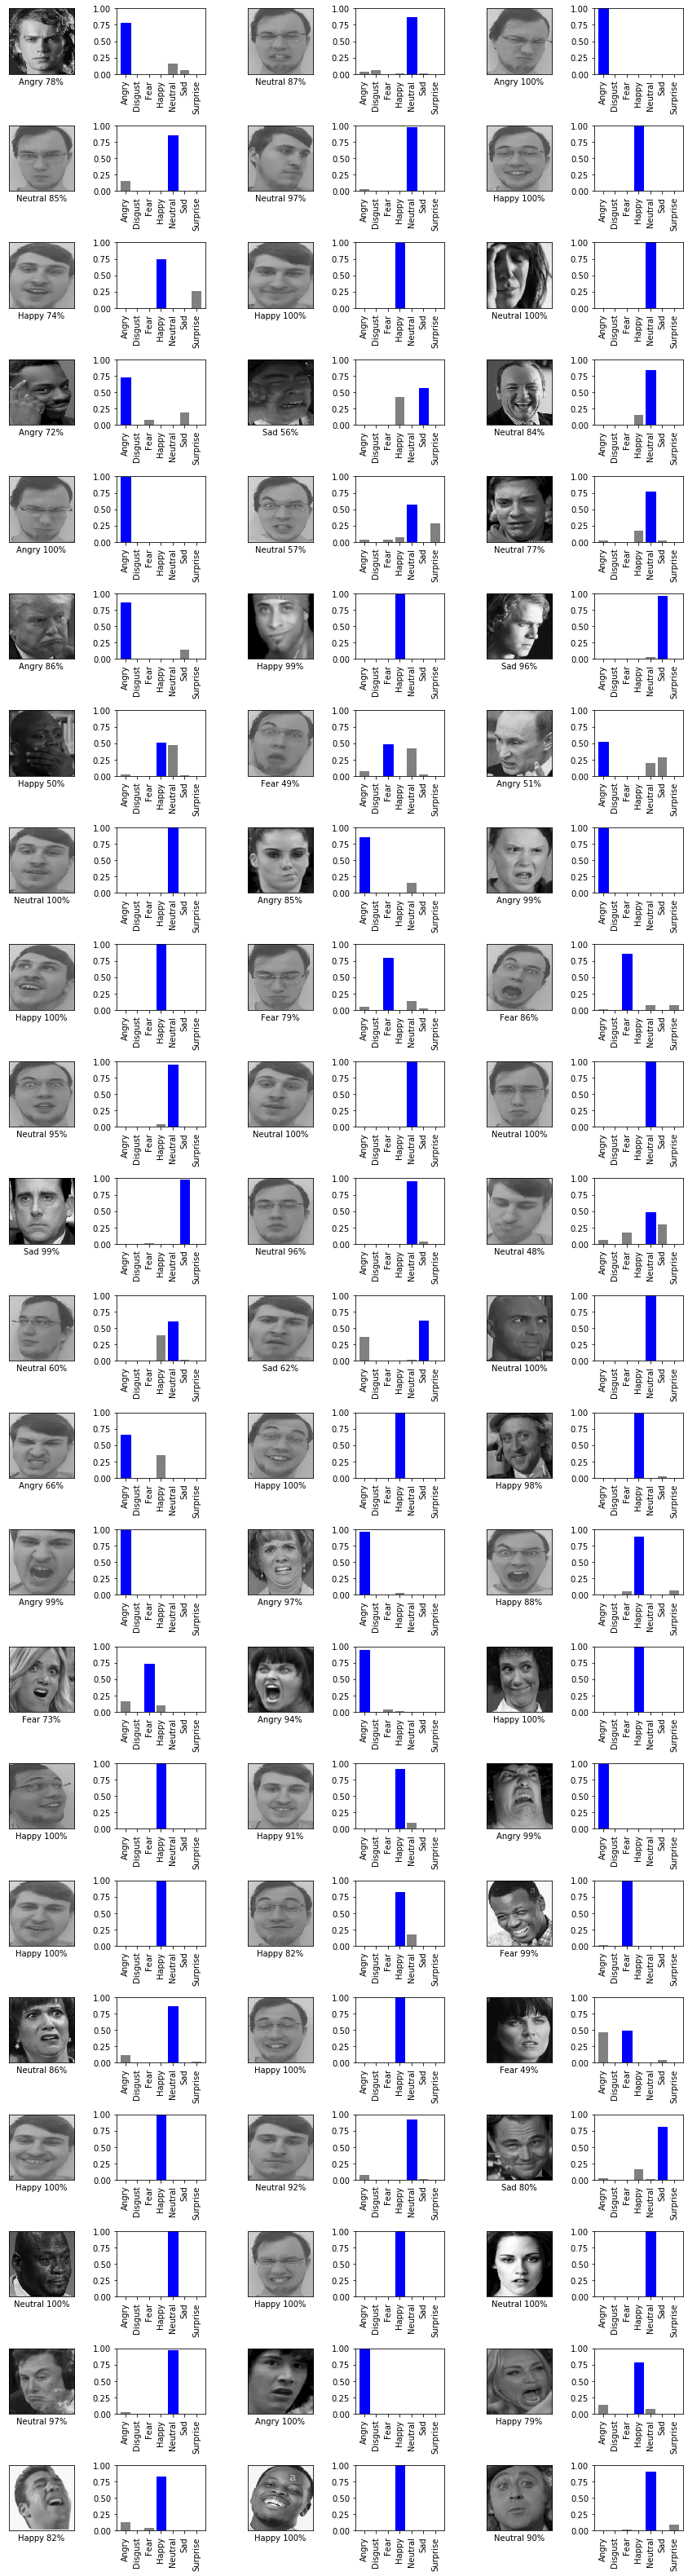

In [ ]:
import matplotlib.pyplot as plt

class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

def plot_image(i, predictions_array, img):
    predictions_array, img = predictions_array, img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    plt.xlabel("{} {:2.0f}%".format(class_names[predicted_label], 100 * np.max(predictions_array)))

def plot_value_array(i, predictions_array):
    predictions_array
    plt.grid(False)
    plt.xticks(range(7))
    plt.xticks(range(7), class_names, rotation=90)
    thisplot = plt.bar(range(7), predictions_array, color="gray")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    thisplot[predicted_label].set_color('blue')

# Plot images and predictions
num_rows = 22
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(4 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2*i+1)
    plot_image(i, predictions[i], test_images)
    plt.subplot(num_rows, 2 * num_cols, 2*i+2)
    plot_value_array(i, predictions[i])
plt.tight_layout()
plt.show()

The results might be biased, since the train set is very unbalanced. The distribution of images across all 7 classes of emotions is described below.

Total number of images: 35887
- 547 (1.524%) disgust images
- 4002 (11.15%) surprise images
- 4953 (13.8%) angry images
- 5121 (14.27%) fear images
- 6077 (16.93%) sad images
- 6198 (17.27%) neutral images
- 8989 (25.05%) happy images

The average distribution should be 1/7 (14.29%) for each of the classes, but instead we have cases like 25% vs 1.5%.